Here is the interface corresponding to Task 2. It loads the pre-saved model and makes predictions based on the entered shop and item.

![Example Image](./app.png)


## Result
After training and evaluating with backtesting, the corresponding results are as follows:
- Backtest 1: SMAPE = 5.7459449510300535%, RSME = 0.4817399352672144
- Backtest 2: SMAPE = 6.240552259102964%, RSME = 0.39269648116043704
- Backtest 3: SMAPE = 4.98832283359187%, RSME = 0.7042590867315942
- Backtest 4: SMAPE = 4.027142471054767%, RSME = 0.5048094055038669
- Backtest 5: SMAPE = 4.342775272686345%, RSME = 0.5481591638379509

## The main steps
- Loading and Exploring Data
- Exploratory Data Analysis
- Data Wrangling
- Model Selection
- Prediction

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, date_format, col, when
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import col, sum as spark_sum

from lightgbm import LGBMRegressor, early_stopping
from itertools import product
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loading and Exploring Data

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("ForecastFurtureSales").getOrCreate()

# Load the datasets
train = spark.read.csv('./train.csv', header=True, inferSchema=True)
test = spark.read.csv('./test.csv', header=True, inferSchema=True)
items = spark.read.csv('./items.csv', header=True, inferSchema=True)
item_categories = spark.read.csv('./item_categories.csv', header=True, inferSchema=True)
shops = spark.read.csv('./shops.csv', header=True, inferSchema=True)

# Display basic information about each dataset
dataframes = {'train': train, 'test': test, 'items': items, 'item_categories': item_categories, 'shops': shops}

for name, df in dataframes.items():
    print(f"Schema of {name}:")
    df.printSchema()

    print(f"Number of rows in {name}: {df.count()}")

    print(f"Sample data from {name}:")
    df.show(5)
    print("\n\n")

24/10/08 21:02:37 WARN Utils: Your hostname, zenbook resolves to a loopback address: 127.0.1.1; using 192.168.2.35 instead (on interface wlo1)
24/10/08 21:02:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 21:02:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Schema of train:
root
 |-- _c0: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- date_block_num: integer (nullable = true)
 |-- shop_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- item_price: double (nullable = true)
 |-- item_cnt_day: double (nullable = true)
 |-- item_category_id: integer (nullable = true)

Number of rows in train: 2935849
Sample data from train:
+---+----------+--------------+-------+-------+----------+------------+----------------+
|_c0|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|item_category_id|
+---+----------+--------------+-------+-------+----------+------------+----------------+
|  0|02.01.2013|             0|     59|  22154|     999.0|         1.0|              37|
|  1|03.01.2013|             0|     25|   2552|     899.0|         1.0|              58|
|  2|05.01.2013|             0|     25|   2552|     899.0|        -1.0|              58|
|  3|06.01.2013|             0|     25|   2554|   17

24/10/08 21:02:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


Number of rows in test: 214200
Sample data from test:
+---+-------+-------+
| ID|shop_id|item_id|
+---+-------+-------+
|  0|      5|   5037|
|  1|      5|   5320|
|  2|      5|   5233|
|  3|      5|   5232|
|  4|      5|   5268|
+---+-------+-------+
only showing top 5 rows




Schema of items:
root
 |-- item_id: integer (nullable = true)
 |-- item_category_id: integer (nullable = true)

Number of rows in items: 22170
Sample data from items:
+-------+----------------+
|item_id|item_category_id|
+-------+----------------+
|      0|              40|
|      1|              76|
|      2|              40|
|      3|              40|
|      4|              40|
+-------+----------------+
only showing top 5 rows




Schema of item_categories:
root
 |-- item_category_id: integer (nullable = true)

Number of rows in item_categories: 84
Sample data from item_categories:
+----------------+
|item_category_id|
+----------------+
|               0|
|               1|
|               2|
|             

# Exploratory Data Analysis

In [4]:
# Convert 'date' column to DateType
processed_train = train.withColumn('date', to_date(train['date'], 'dd.MM.yyyy'))

processed_train.show(5)

+---+----------+--------------+-------+-------+----------+------------+----------------+
|_c0|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|item_category_id|
+---+----------+--------------+-------+-------+----------+------------+----------------+
|  0|2013-01-02|             0|     59|  22154|     999.0|         1.0|              37|
|  1|2013-01-03|             0|     25|   2552|     899.0|         1.0|              58|
|  2|2013-01-05|             0|     25|   2552|     899.0|        -1.0|              58|
|  3|2013-01-06|             0|     25|   2554|   1709.05|         1.0|              58|
|  4|2013-01-15|             0|     25|   2555|    1099.0|         1.0|              56|
+---+----------+--------------+-------+-------+----------+------------+----------------+
only showing top 5 rows



24/10/08 21:02:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


### Ensure the shops and items datasets include all relevant information from the train set and vice versa

In [5]:
unique_shops = processed_train.select('shop_id').distinct()
missing_shops = processed_train.join(unique_shops, on='shop_id', how='left_anti')
missing_count = missing_shops.count()

print(f'Number of missing shops: {missing_count}')

Number of missing shops: 0


In [6]:
unique_items = processed_train.select('item_id').distinct()
missing_items = processed_train.join(unique_items, on='item_id', how='left_anti')
missing_items_count = missing_items.count()

print(f'Number of missing items: {missing_items_count}')

Number of missing items: 0


In [7]:
unique_categories = processed_train.select('item_category_id').distinct()
missing_categories = processed_train.join(unique_categories, on='item_category_id', how='left_anti')
missing_categories_count = missing_categories.count()

print(f'Number of missing categories: {missing_categories_count}')

Number of missing categories: 0


In [8]:
missing_items = test.join(items, on='item_id', how='left_anti')

print("The item_ids not present in the items list:")
missing_items.show()

The item_ids not present in the items list:
+-------+---+-------+
|item_id| ID|shop_id|
+-------+---+-------+
+-------+---+-------+



In [9]:
missing_shop = test.join(shops, on='shop_id', how='left_anti')

print("The shop_ids not present in the shops list:")
missing_shop.show()

The shop_ids not present in the shops list:
+-------+---+-------+
|shop_id| ID|item_id|
+-------+---+-------+
+-------+---+-------+



### List some negative values in the quantity and price columns

In [10]:
negative_price_items = processed_train.filter(processed_train['item_price'] < 0)

print("Items with negative prices:")
negative_price_items.show()

Items with negative prices:


24/10/08 21:02:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


+------+----------+--------------+-------+-------+----------+------------+----------------+
|   _c0|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|item_category_id|
+------+----------+--------------+-------+-------+----------+------------+----------------+
|484683|2013-05-15|             4|     32|   2973|      -1.0|         1.0|              19|
+------+----------+--------------+-------+-------+----------+------------+----------------+



In [11]:
negative_cnt_items = processed_train.filter(processed_train['item_cnt_day'] < 0)

print("Items with negative item_cnt_day values:")
negative_cnt_items.show()

Items with negative item_cnt_day values:
+----+----------+--------------+-------+-------+----------+------------+----------------+
| _c0|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|item_category_id|
+----+----------+--------------+-------+-------+----------+------------+----------------+
|   2|2013-01-05|             0|     25|   2552|     899.0|        -1.0|              58|
| 148|2013-01-23|             0|     25|   2321|     999.0|        -1.0|              28|
| 175|2013-01-07|             0|     25|   2199|    1449.0|        -1.0|              58|
| 807|2013-01-02|             0|     25|   2330|     599.0|        -1.0|              30|
|1041|2013-01-13|             0|     25|   5034|    1989.0|        -1.0|              23|
|1193|2013-01-02|             0|     25|   5651|    5490.0|        -1.0|               2|
|1674|2013-01-07|             0|     25|   4093|     899.0|        -1.0|              58|
|1825|2013-01-02|             0|     25|   4249|   1894.87|

24/10/08 21:02:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


### Item price distribution

24/10/08 21:02:54 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


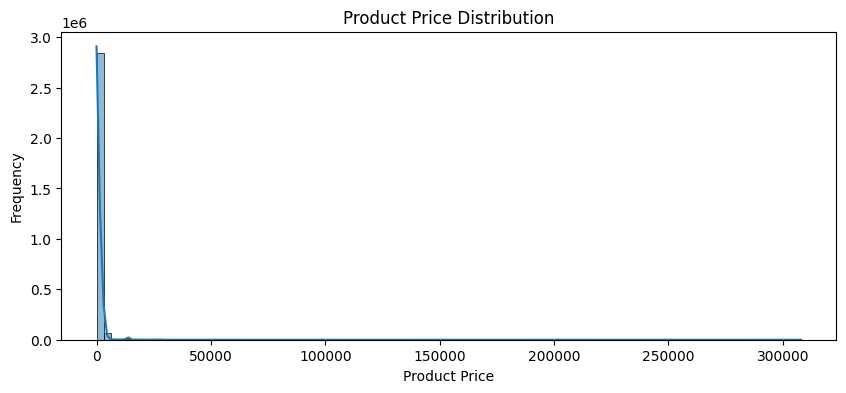

In [12]:
price_data = processed_train.filter(processed_train['item_price'] > 0).toPandas()

plt.figure(figsize=(10, 4))
sns.histplot(price_data['item_price'], bins=100, kde=True)
plt.title('Product Price Distribution')
plt.xlabel('Product Price')
plt.ylabel('Frequency')
plt.show()

### The return rate of items sold

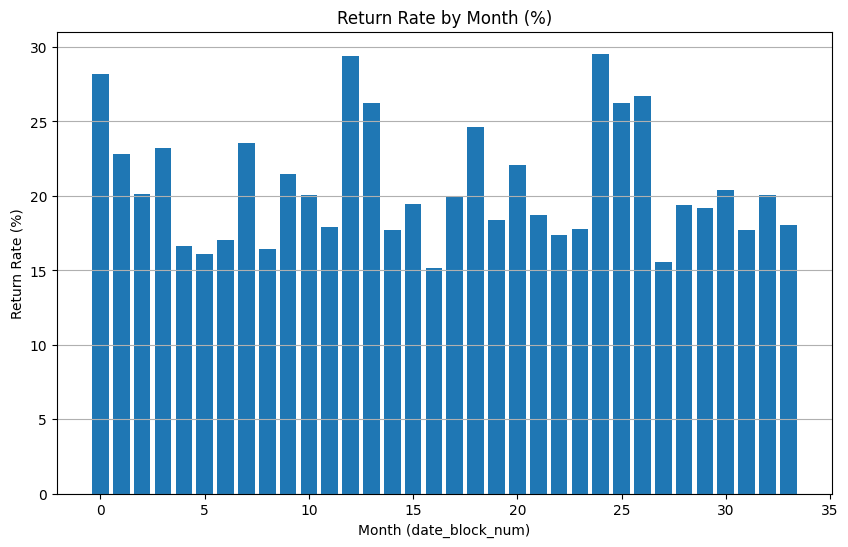

In [13]:
monthly_returns = negative_cnt_items.groupBy('date_block_num') \
    .agg(F.sum('item_cnt_day').alias('total_returns'))
monthly_total_sales = processed_train.groupBy('date_block_num') \
    .agg(F.sum('item_cnt_day').alias('total_sales'))
return_rate = monthly_returns.join(monthly_total_sales, 'date_block_num') \
    .select('date_block_num', 
            (F.col('total_returns') / F.abs(F.col('total_sales')) * 100).alias('return_rate')).toPandas()

# Plotting the return rate per month
plt.figure(figsize=(10, 6))
plt.bar(return_rate['date_block_num'], np.abs(return_rate['return_rate']*100))
plt.title('Return Rate by Month (%)')
plt.xlabel('Month (date_block_num)')
plt.ylabel('Return Rate (%)')
plt.grid(axis='y')  # Optional: Adds vgrid lines for better readability
plt.show()

Several reasons could lead to this result: incorrect data entry, returns, and products not meeting quality standards for sale, among others. However, with such a high percentage, it is unlikely that this is due to data entry errors; it suggests some underlying significance. We can see that whether it’s returns or products not meeting quality standards, the outcome is that the quantity of those items cannot be sold on that day. Therefore, we should replace these numbers with 0 in the following steps. As for the negative value in the 'price' column, there could also be multiple reasons for this; however, since there is only one observation with a negative value, we will treat it as an outlier and remove it in the next step.

However, on the shoo side, it is necessary to determine the reasons for payment to improve product quality and customer service, and minimize payment levels.

### Time Series Plot for Total Items Sold by Date

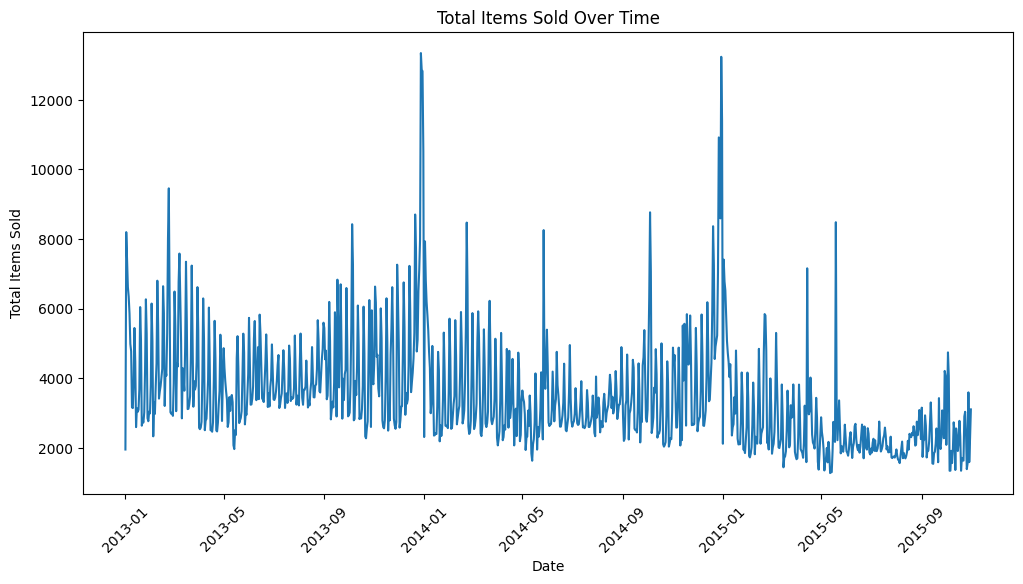

In [14]:
grouped_sales = processed_train.groupBy(['date', 'shop_id', 'item_id']) \
    .agg(F.sum('item_cnt_day').alias('total_items_sold'))
datewise_sales = grouped_sales.groupBy('date') \
    .agg(F.sum('total_items_sold').alias('total_items_sold'))

datewise_sales_pd = datewise_sales.toPandas()
datewise_sales_pd['date'] = pd.to_datetime(datewise_sales_pd['date'], format='%d.%m.%Y')

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='total_items_sold', data=datewise_sales_pd)
plt.title('Total Items Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Items Sold')
plt.xticks(rotation=45)
plt.show()

The plot shows fluctuating total items sold over time, with notable spikes indicating specific events or promotions. 

### Bar Plot for Total Items Sold by Shop

/tmp/ipykernel_7729/3297590260.py:5: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='shop_id', y='total_items_sold', data=shopwise_sales_pd, palette='viridis')


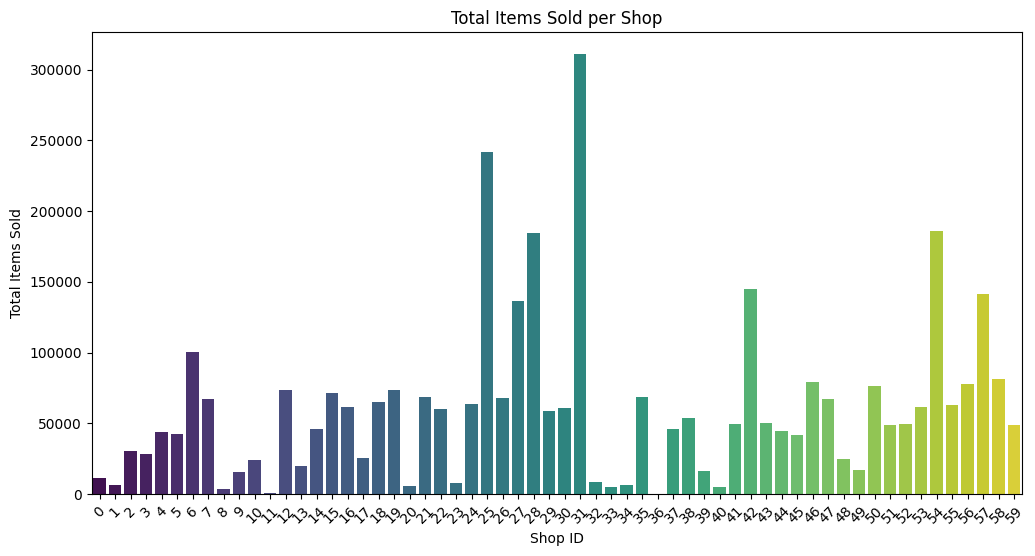

In [15]:
shopwise_sales = grouped_sales.groupby('shop_id').agg(spark_sum('total_items_sold').alias('total_items_sold'))
shopwise_sales_pd = shopwise_sales.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='shop_id', y='total_items_sold', data=shopwise_sales_pd, palette='viridis')
plt.title('Total Items Sold per Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Items Sold')
plt.xticks(rotation=45)
plt.show()

High-performing shops, shown in darker shades, likely employ effective strategies that others can adopt, while underperforming shops, in lighter shades, need targeted support to boost sales through improved inventory, pricing, and marketing. This analysis aids in resource allocation, ensuring that assistance is provided to both high and low-performing shops. However, the model below does not really delve into the influence of shops with a high number of items sold.

In [16]:
processed_train.show(5)

+---+----------+--------------+-------+-------+----------+------------+----------------+
|_c0|      date|date_block_num|shop_id|item_id|item_price|item_cnt_day|item_category_id|
+---+----------+--------------+-------+-------+----------+------------+----------------+
|  0|2013-01-02|             0|     59|  22154|     999.0|         1.0|              37|
|  1|2013-01-03|             0|     25|   2552|     899.0|         1.0|              58|
|  2|2013-01-05|             0|     25|   2552|     899.0|        -1.0|              58|
|  3|2013-01-06|             0|     25|   2554|   1709.05|         1.0|              58|
|  4|2013-01-15|             0|     25|   2555|    1099.0|         1.0|              56|
+---+----------+--------------+-------+-------+----------+------------+----------------+
only showing top 5 rows



24/10/08 21:03:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
 Schema: _c0, date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_category_id
Expected: _c0 but found: 
CSV file: file:///mnt/DATA/Intern/testhome_datanest/Datanest_DS_MLE_takehome_test/Datanest_DS_MLE_takehome_test/train.csv


### Monthly sales trend

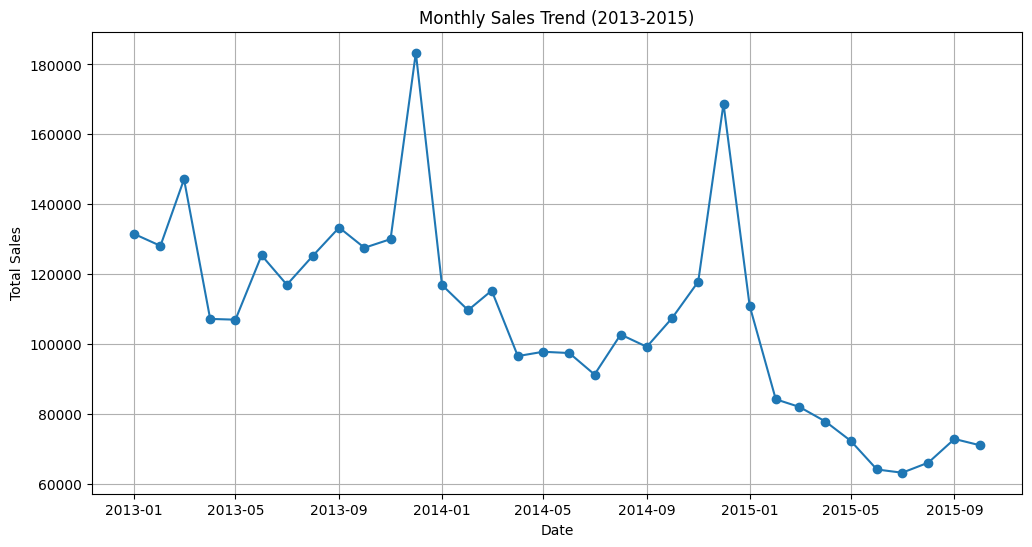

In [17]:
processed_train = processed_train.withColumn('year', F.year('date')) \
                       .withColumn('month', F.month('date'))

monthly_sales = (processed_train
                 .groupBy(['year', 'month'])
                 .agg(F.sum('item_cnt_day').alias('total_sales')))

monthly_sales = (monthly_sales
                 .withColumn('date', F.to_date(F.concat_ws('-', 
                               monthly_sales.year, 
                               monthly_sales.month, 
                               F.lit(1))))
                 .orderBy('date'))

monthly_sales_pd = monthly_sales.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_pd['date'], monthly_sales_pd['total_sales'], marker='o')
plt.title('Monthly Sales Trend (2013-2015)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

### Top 10 selling items

/tmp/ipykernel_7729/1014271165.py:10: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_id', y='total_sales', data=top_items_pd, palette='viridis')


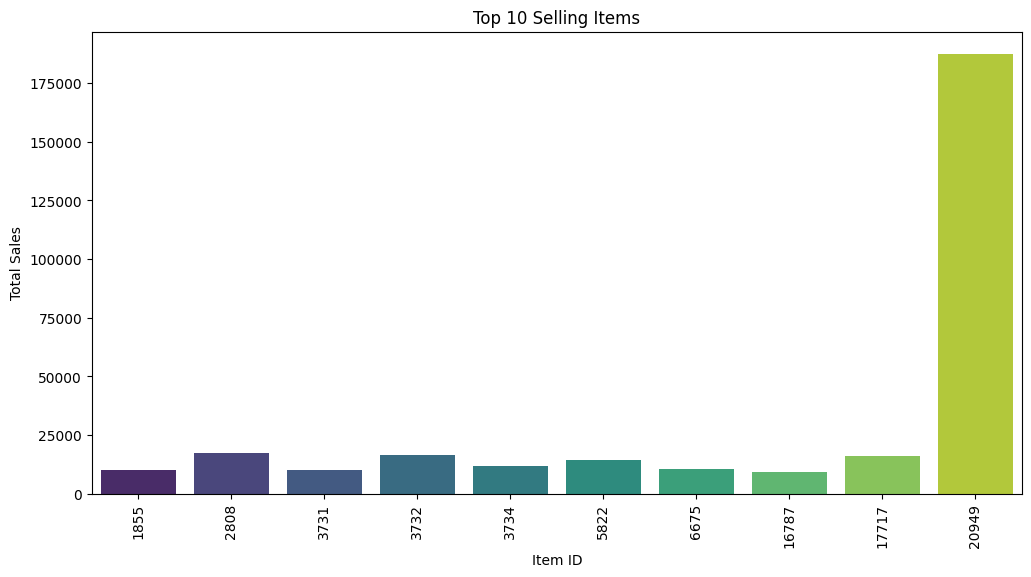

In [18]:
top_items = (processed_train.groupBy('item_id')
                          .agg(F.sum('item_cnt_day').alias('total_sales'))
                          .orderBy('total_sales', ascending=False)
                          .limit(10))

top_items = top_items.join(items.select('item_id'), on='item_id', how='inner')
top_items_pd = top_items.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='item_id', y='total_sales', data=top_items_pd, palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 10 Selling Items')
plt.xlabel('Item ID')
plt.ylabel('Total Sales')
plt.show()

### Top 10 selling shops

/tmp/ipykernel_7729/742579718.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='shop_id', y='total_sales', data=top_shops_pd, palette='viridis')


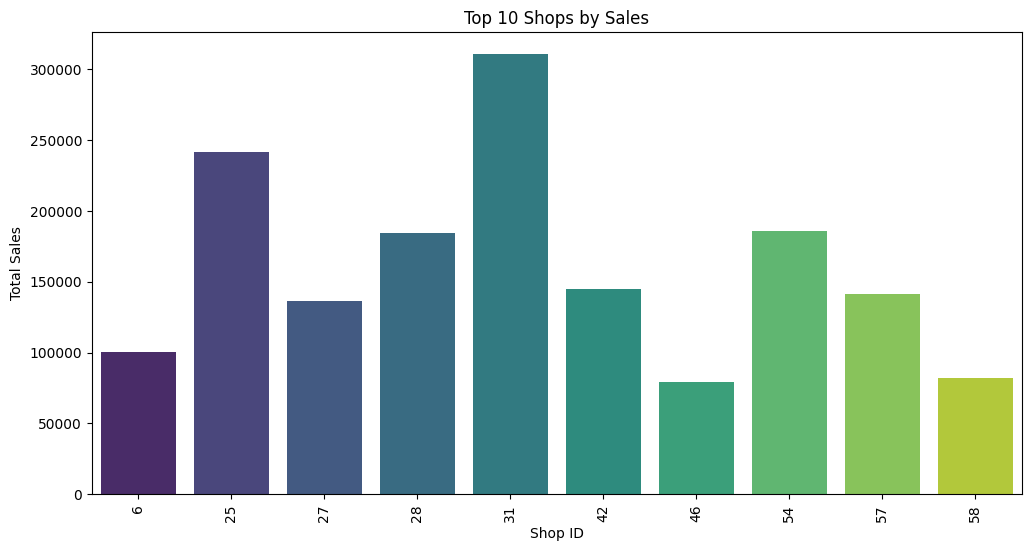

In [19]:
top_shops = (processed_train.groupBy('shop_id')
                         .agg(F.sum('item_cnt_day').alias('total_sales'))
                         .orderBy('total_sales', ascending=False)
                         .limit(10))

top_shops = top_shops.join(shops.select('shop_id'), on='shop_id', how='inner')

# Collect the data to a Pandas DataFrame for plotting
top_shops_pd = top_shops.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='shop_id', y='total_sales', data=top_shops_pd, palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 10 Shops by Sales')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')
plt.show()

### The relationship between price and sales:

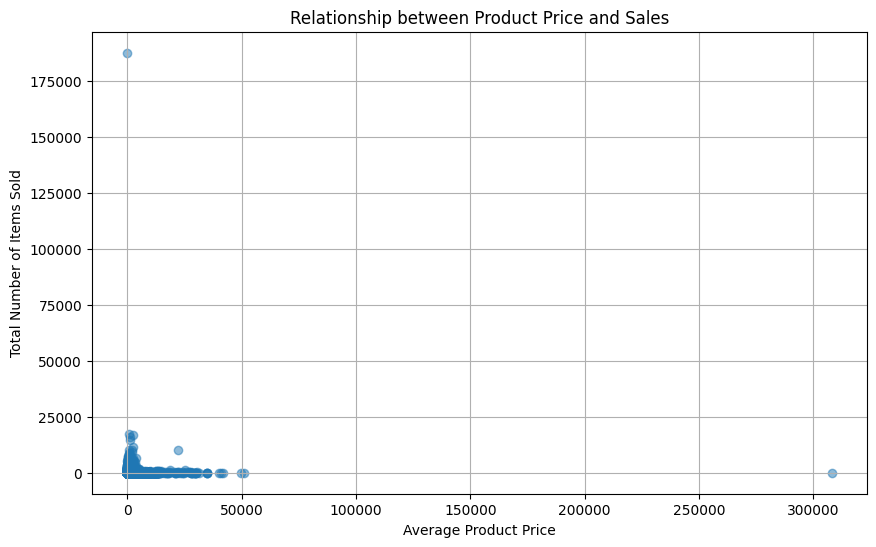

In [20]:
item_stats = processed_train.groupBy('item_id').agg(
    F.mean('item_price').alias('average_price'),
    F.sum('item_cnt_day').alias('total_sales')
)

item_stats_pd = item_stats.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(item_stats_pd['average_price'], item_stats_pd['total_sales'], alpha=0.5)
plt.title('Relationship between Product Price and Sales')
plt.xlabel('Average Product Price')
plt.ylabel('Total Number of Items Sold')
plt.grid() 
plt.show()

This scatter plot reveals a clear negative correlation between product price and sales volume. Most sales cluster at lower price points, with the highest volume around 175,000 units sold at one of the lowest prices. As prices increase, sales drop sharply, forming a long-tail distribution. There's a high concentration of products priced below 50,000, with few high-priced outliers selling in very small quantities. This pattern suggests high price sensitivity among customers and potentially different market segments - a large volume, low-price segment and a niche high-price segment.

### Sales trends and seasonality

<Figure size 1200x1000 with 0 Axes>

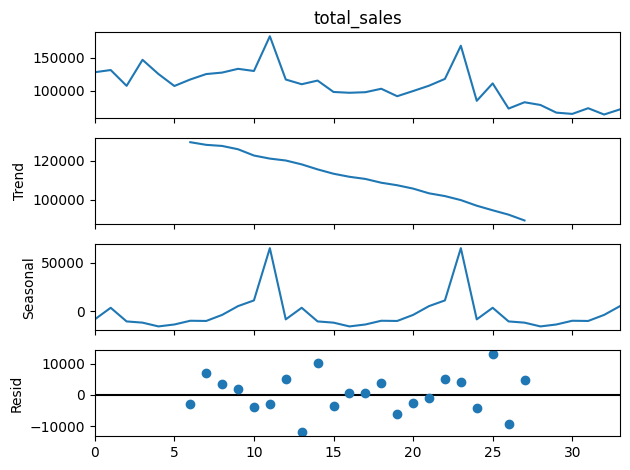

In [21]:
monthly_sales = processed_train.groupBy('date_block_num').agg(F.sum('item_cnt_day').alias('total_sales'))

monthly_sales_pd = monthly_sales.toPandas()

result = seasonal_decompose(monthly_sales_pd['total_sales'], model='additive', period=12)

plt.figure(figsize=(12, 10))
result.plot()
plt.show()

The top panel displays the original time series, revealing fluctuations in sales over time. The second panel illustrates a clear downward trend in sales. The third panel highlights strong seasonal patterns, with notable peaks likely corresponding to specific times of the year such as black friday, double day. The bottom panel shows residuals, which appear relatively random, suggesting the model captures most of the data's structure.

# Data wrangling

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as F_sum, min as F_min, max as F_max, last as F_last, stddev as F_stddev
from pyspark.sql import Window
from itertools import product

    class DataWrangler:
    def __init__(self, spark):
        self.spark = spark

    def _data_cleaning(self, df, flag=False):
        df = df.select('shop_id', 'item_id', 'date_block_num', 'item_cnt_day')
            
        df = df.withColumn('item_cnt_day', when(col('item_cnt_day') < 0, 0).otherwise(col('item_cnt_day')))
        return df

    def _sample_shops_items(self, df, shops, items, num_shops=60, num_items=25000):
        total_shops = shops.count()
        total_items = items.count()

        sampled_shop_ids = [row.shop_id for row in shops.select('shop_id').distinct()
                                .sample(False, num_shops / total_shops).collect()]

        sampled_item_ids = [row.item_id for row in df.select('item_id').distinct()
                                .sample(False, num_items / total_items).collect()]

        return sampled_shop_ids, sampled_item_ids

    def _create_combinations(self, df, sampled_shop_ids=None, sampled_item_ids=None):
        if sampled_shop_ids is None:
            sampled_shop_ids = [row.shop_id for row in df.select('shop_id').distinct().collect()]
        if sampled_item_ids is None:
            sampled_item_ids = [row.item_id for row in df.select('item_id').distinct().collect()]

        shop_item_combinations = self.spark.createDataFrame(
            list(product(sampled_shop_ids, sampled_item_ids)),
            schema=['shop_id', 'item_id']
        )
        date_block_nums = df.select('date_block_num').distinct()
        combinations = date_block_nums.crossJoin(shop_item_combinations)
        data_combinations = combinations.select('date_block_num', 'shop_id', 'item_id')
        return data_combinations

    def _calculate_monthly_sales(self, df, data_combinations=None):
        monthly_sales = (
            df.groupBy(['shop_id', 'item_id', 'date_block_num'])
            .agg(F_sum('item_cnt_day').alias('item_cnt_month'))
        )
        if data_combinations is not None:
            data_with_sales = data_combinations.join(
                monthly_sales,
                on=['shop_id', 'item_id', 'date_block_num'],
                how='left'
            )
        else: 
            data_with_sales = monthly_sales
        data_with_sales = data_with_sales.fillna({'item_cnt_month': 0})
        data_with_sales = data_with_sales.select('shop_id', 'item_id', 'date_block_num', 'item_cnt_month')
        return data_with_sales
    

    def _generate_aggregations_over_time_frames(self, agg_func, input_column, output, order_by_cols):
        aggregation_info = [
            ((0, 0), f'{output}_last_1m'),  # Last 1 month
            ((-1, 0), f'{output}_last_2m'),  # Last 2 months
            ((-2, 0), f'{output}_last_3m'),  # Last 3 months
            ((-3, 0), f'{output}_last_4m'),  # Last 4 months
            ((-4, 0), f'{output}_last_5m'),  # Last 5 months
        ]
    
        window = Window.partitionBy('shop_id', 'item_id').orderBy(order_by_cols)
    
        aggregations = []
        for agg in aggregation_info:
            aggregations.append(
                agg_func(F.col(input_column))
                .over(window.rowsBetween(agg[0][0], agg[0][1]))
                .alias(agg[1])
            )

        return aggregations

    def _generate_features_for_input_column(self, input_column, order_by_cols):
        return [
            *self._generate_aggregations_over_time_frames(F.min, input_column, f'min_{input_column}', order_by_cols),
            *self._generate_aggregations_over_time_frames(F.max, input_column, f'max_{input_column}', order_by_cols),
            *self._generate_aggregations_over_time_frames(F.last, input_column, f'last_{input_column}', order_by_cols),
            *self._generate_aggregations_over_time_frames(F.stddev, input_column, f'std_{input_column}', order_by_cols),
        ]
        
    def _generate_target(self, input_column, output, order_by_cols):
        aggregation_info = [
            ((1, 1), f'{output}_1m'),
        ]
    
        window = Window.partitionBy('shop_id', 'item_id').orderBy(order_by_cols)
    
        aggregations = []
        for agg in aggregation_info:
            aggregations.append(
                F.sum(F.col(input_column))
                .over(window.rowsBetween(agg[0][0], agg[0][1]))
                .alias(agg[1])
        )
    
        return aggregations

    def _extract_historical_data(self, train_data, test_data):
        min_test_date_block_num = test_data.agg({"date_block_num": "min"}).collect()[0][0]
        
        historical_data = train_data.filter(
            (col('date_block_num') >= (min_test_date_block_num - 5)) & 
            (col('date_block_num') < min_test_date_block_num)
        )
        
        test_shop_item = test_data.select('shop_id', 'item_id').distinct()
        
        historical_data = historical_data.join(
            test_shop_item,
            on=['shop_id', 'item_id'],
            how='inner'
        )
        
        return historical_data

    def _process_data(self, data_to_train):
        ORDER_BY_COLS = ['shop_id', 'item_id', 'date_block_num']

        processed_data = data_to_train.select("*",
                                              *self._generate_features_for_input_column('item_cnt_month', ORDER_BY_COLS),
                                              *self._generate_target('item_cnt_month', 'target', ORDER_BY_COLS))
        return processed_data

    def prepare_data(self, processed_train, shops, items, num_shops=60, num_items=1000):
        X = self._data_cleaning(processed_train)

        sampled_shop_ids, sampled_item_ids = self._sample_shops_items(X, shops, items, num_shops, num_items)

        combination = self._create_combinations(X, sampled_shop_ids, sampled_item_ids)

        processed_data = self._calculate_monthly_sales(X, combination)

        data_to_train = self._process_data(processed_data)

        return data_to_train

    def process_test_data(self, train_data, test_data):
        processed_train = self._data_cleaning(train_data, True)
        
        historical_data = self._extract_historical_data(processed_train, test_data)
        
        combined_data = historical_data.unionByName(test_data)

        processed_test_data = self._calculate_monthly_sales(combined_data)

        data_to_test = self._process_data(processed_test_data)

        return data_to_test


In [23]:
data_wrangler = DataWrangler(spark)

processed_data = data_wrangler.prepare_data(processed_train, shops, items)

processed_data.show()

+-------+-------+--------------+--------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+---------+
|shop_id|item_id|date_block_num|item_cnt_month|min_item_cnt_month_last_1m|min_item_cnt_month_last_2m|min_item_cnt_month_last_3m|min_item_cnt_month_last_4m|min_item_cnt_month_last_5m|max_item_cnt_month_last_1m|max_item_cnt_month_last_2m|max_item_cnt_month_last_3m|max_item_cnt_month_last_4m|max_item_cnt_month_last_5m|last_item_cnt_month_last_1m|last_item_cnt_month_last_2m|last_item_cnt_month_last

# Model selection

In [24]:
class ModelTrainer:
    def __init__(self):
        self.model = None  

    def create_backtest_splits(self, df, n_splits=5, validation_months=2, test_months=1, date_column='date_block_num'):
        df = df.sort_values(date_column)

        months = df[date_column].unique()
        total_months = len(months) - 1
        split_size = validation_months + test_months
        max_train_end = total_months - n_splits * split_size

        if max_train_end <= 0:
            raise ValueError("The number of months of data is not enough to create splits for the backtest.")

        splits = []
        for i in range(n_splits):
            train_end = max_train_end + i * split_size
            val_start = train_end
            val_end = val_start + validation_months
            test_start = val_end
            test_end = test_start + test_months

            train_months = months[:train_end]
            val_months = months[val_start:val_end]
            test_months_list = months[test_start:test_end]

            train_data = df[df[date_column].isin(train_months)]
            val_data = df[df[date_column].isin(val_months)]
            test_data = df[df[date_column].isin(test_months_list)]

            splits.append((train_data, val_data, test_data))

        return splits

    def smape(self, y_true, y_pred):
        return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-8))

    def train_model(self, processed_data, n_splits=5, validation_months=2, test_months=1):
        if not isinstance(processed_data, pd.DataFrame):
            processed_data = processed_data.toPandas()

        splits = self.create_backtest_splits(processed_data, n_splits=n_splits, validation_months=validation_months, test_months=test_months, date_column='date_block_num')

        results = []
        self.model = LGBMRegressor(n_estimators=5000, learning_rate=0.01, max_depth=32, num_leaves=128)

        for i, (train_data, val_data, test_data) in enumerate(splits):
            print(f"\nBacktest lần {i + 1}")

            y_train = train_data['target_1m']
            X_train = train_data.drop(['date_block_num', 'target_1m'], axis=1)

            y_val = val_data['target_1m']
            X_val = val_data.drop(['date_block_num', 'target_1m'], axis=1)

            y_test = test_data['target_1m']
            X_test = test_data.drop(['date_block_num', 'target_1m'], axis=1)

            X_train = X_train.fillna(0)
            X_val = X_val.fillna(0)
            X_test = X_test.fillna(0)

            self.model.fit(
                X_train,
                y_train,
                eval_metric='rmse',
                eval_set=[(X_val, y_val)],
                callbacks=[early_stopping(stopping_rounds=500)],
            )

            best_iteration = self.model.best_iteration_
            print(f"Best number of loops: {best_iteration}")

            y_pred = np.round(self.model.predict(X_test))
            smape_value = self.smape(y_test.values, y_pred)
            rmse = root_mean_squared_error(y_test.values, y_pred)
            print(f"SMAPE on test set: {smape_value}%")
            print(f"RMSE on test set: {rmse}%")

            results.append({
                'backtest': i + 1,
                'best_iteration': best_iteration,
                'smape': smape_value,
                'rsme': rmse
            })

        return results

    def predict(self, processed_test_data):
        if not isinstance(processed_test_data, pd.DataFrame):
            test_df = processed_test_data.toPandas()
        else:
            test_df = processed_test_data.copy()

        X_test = test_df.drop(['date_block_num', 'target_1m', 'shop_id', 'item_id'], axis=1, errors='ignore')
        X_test = X_test.fillna(0)

        predictions = np.round(self.model.predict(X_test))

        test_df['prediction'] = predictions

        return test_df[['shop_id', 'item_id', 'date_block_num', 'prediction']]


In [25]:
model_trainer = ModelTrainer()

processed_data = processed_data.drop(*['shop_id', 'item_id', 'item_cnt_month']).toPandas()

results = model_trainer.train_model(processed_data)

for res in results:
    print(f"Backtest {res['backtest']}: SMAPE = {res['smape']}%, RSME = {res['rsme']}")


Backtest lần 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 1128600, number of used features: 19
[LightGBM] [Info] Start training from score 0.079436
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Prediction

In [26]:
data_wrangler = DataWrangler(spark)
test = test.withColumn('date_block_num', F.lit(34))
test = test.withColumn('item_cnt_day', F.lit(0))
test = test.drop('ID')
processed_test = data_wrangler.process_test_data(processed_train, test)
processed_test = processed_test.filter(processed_test['date_block_num'] == 34)
processed_test.show(5)

+-------+-------+--------------+--------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+---------+
|shop_id|item_id|date_block_num|item_cnt_month|min_item_cnt_month_last_1m|min_item_cnt_month_last_2m|min_item_cnt_month_last_3m|min_item_cnt_month_last_4m|min_item_cnt_month_last_5m|max_item_cnt_month_last_1m|max_item_cnt_month_last_2m|max_item_cnt_month_last_3m|max_item_cnt_month_last_4m|max_item_cnt_month_last_5m|last_item_cnt_month_last_1m|last_item_cnt_month_last_2m|last_item_cnt_month_last

In [36]:
processed_test_data = processed_test.drop('item_cnt_month').toPandas()
predictions = model_trainer.predict(processed_test_data)

print(predictions[predictions['prediction']>0])

        shop_id  item_id  date_block_num  prediction
69            2     1484              34         1.0
74            2     1537              34         1.0
84            2     1583              34         1.0
101           2     1914              34         1.0
104           2     2047              34         1.0
...         ...      ...             ...         ...
213633       59    16205              34         1.0
213639       59    16227              34         1.0
213763       59    17775              34         1.0
214185       59    22087              34         1.0
214186       59    22088              34         1.0

[8773 rows x 4 columns]


# Save model

In [61]:
import joblib

joblib.dump(model_trainer, 'trained_model.pkl')

['trained_model.pkl']